In [ ]:
from google.colab import drive
import re
from torchtext.vocab import Vocab
import torch
import torchvision
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence
import torchvision.transforms as T
import pickle as pkl
from PIL import Image
from copy import deepcopy
import matplotlib.pyplot as plt

class TextNumericalizer():
	def __init__(self, vocab, tokenizer):
		self.vocab = vocab

	def tokenize(self, sentence):
		return (re.sub(r'[^\w\s]', '', sentence).lower()).split(" ")

	def SentenceToVector(self, sentence):
		return [self.vocab.stoi[token.lower()] for token in self.tokenize(sentence)]

	def VectorToSentence(self, vector):
		return [self.vocab.itos[integer] for integer in vector]
  
	def getVocabularyLength(self):
		return len(self.vocab.stoi.keys())

drive.mount("/content/drive/")
TN = pkl.load(open("/content/drive/MyDrive/Data/TextNumericalizer.pkl","rb"))
BATCH_SIZE = 128

class ImgCapDataset(Dataset):
    def __init__(self, X, Y, TN, transform=None):
        assert len(X)==len(Y), "Data should be of the same length! [Error: X(" + str(len(X)) + ") != Y(" + str(lenY) + ")]"
        self.X = X
        self.Y = Y
        self.TN = TN
        self.transform = transform

    def __getitem__(self, index):
        temp = deepcopy(self.Y[index])
        for i in range(len(self.Y[index])):
            temp[i] = re.sub(r'[^\w\s]', '', temp[i]).lower()

        return self.transform(self.X[index]), torch.tensor([self.TN.vocab.stoi["<sos>"]]+self.TN.SentenceToVector(temp[0])+[self.TN.vocab.stoi["<eos>"]], dtype=torch.long), [self.TN.SentenceToVector(i) for i in temp]

    def __len__(self):
        return len(self.X)

class CollateFunction():
    def __init__(self, padding):
        self.padding = padding

    def __call__(self, batch):
        return torch.cat([i[0].unsqueeze(0) for i in batch], dim=0), pad_sequence([i[1] for i in batch], batch_first=True, padding_value=self.padding), [i[2] for i in batch]

loader = pkl.load(open("/content/drive/MyDrive/Data/Train/train_loader.pkl","rb"))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Encoder Network
class ENet(torch.nn.Module):
    def __init__(self):
        super(ENet, self).__init__()
        temp = torchvision.models.vgg19(pretrained=True)

        # No Fine-Tuning Of The Pre-Trained Model
        for p in temp.parameters():
            p.requires_grad = False

        self.encoder = torch.nn.Sequential(*list(temp.features.children())[:-2])

        '''
        for c in list(self.encoder.children())[5:]:
            for p in c.parameters():
                p.requires_grad = True
        '''

        self.feats = torch.nn.AdaptiveAvgPool2d((14,14))

    def forward(self, x):
        enc = self.encoder(x)
        enc = self.feats(enc)
        enc = enc.permute(0, 2, 3, 1)
        enc = enc.view(-1, 196, 512)

        return enc

# Bahdanau Attention Network
class ANet(torch.nn.Module):
    def __init__(self):
        super(ANet, self).__init__()
        self.v = torch.nn.Linear(512, 1)
        self.W = torch.nn.Linear(512, 512)
        self.U = torch.nn.Linear(512, 512)

    def forward(self, feats, h_state):
        U = self.U(h_state).unsqueeze(dim=1)
        W = self.W(feats)
        A = torch.nn.functional.tanh(W+U)
        e = self.v(A).squeeze(dim=2)
        alpha = torch.nn.functional.softmax(e, dim=1)
        context_vector = (feats*alpha.unsqueeze(dim=2)).sum(dim=1)

        return alpha, context_vector

# Decoder Network With Bahdanau Attention Mechanism
class DNet(torch.nn.Module):
    def __init__(self, vocab_size):
        super(DNet, self).__init__()
        self.v_size = vocab_size
        self.ANet = ANet()
        self.init_h = torch.nn.Linear(512, 512)
        self.init_c = torch.nn.Linear(512, 512)
        self.f_beta = torch.nn.Linear(512, 512)
        self.output_layer = torch.nn.Linear(512, vocab_size)
        self.embedding_layer = torch.nn.Embedding(vocab_size, 512)
        self.LSTM = torch.nn.LSTMCell(1024, 512)

    def forward(self, feats, caps):
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        avg = torch.mean(feats, dim=1)
        h = torch.nn.functional.tanh(self.init_h(avg))
        c = torch.nn.functional.tanh(self.init_c(avg))
        T = len(caps[0])-1
        embedded_caps = None

        if(self.training):
            embedded_caps = self.embedding_layer(caps)
        else:
            embedded_caps = self.embedding_layer(torch.zeros(feats.size(0), 1).long().to(device))

        sentences = torch.zeros((feats.size(0), T, self.v_size)).to(device)
        weights = torch.zeros((feats.size(0), T, 196)).to(device)

        for t in range(T):
            alpha, context_vector = self.ANet(feats, h)
            gated_context_vector = torch.nn.functional.sigmoid(self.f_beta(h))*context_vector
            input = None

            if(self.training):
                input = torch.cat((embedded_caps[:, t], gated_context_vector), dim=1)
            else:
                embedded_caps = embedded_caps.squeeze(1) if embedded_caps.dim()==3 else embedded_caps
                input = torch.cat((embedded_caps, gated_context_vector), dim=1)

            h, c = self.LSTM(input, (h, c))
            output = self.output_layer((torch.nn.Dropout(p=0.3))(h))
            sentences[:, t] = output
            weights[:, t] = alpha

            if(not self.training):
                embedded_caps = self.embedding_layer(output.max(1)[1].reshape(feats.size(0), 1))

        return weights, sentences

vocab_size = loader.dataset.TN.getVocabularyLength()

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1698: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


['<sos>', 'a', 'black', 'dog', 'chasing', 'another', 'black', 'dog', 'down', 'a', 'grass', 'covered', 'hill', '<unk>', '<eos>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
['a', 'black', 'dog', 'chasing', 'a', 'black', 'dog', 'through', 'the', 'grass', '<unk>', '<eos>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']


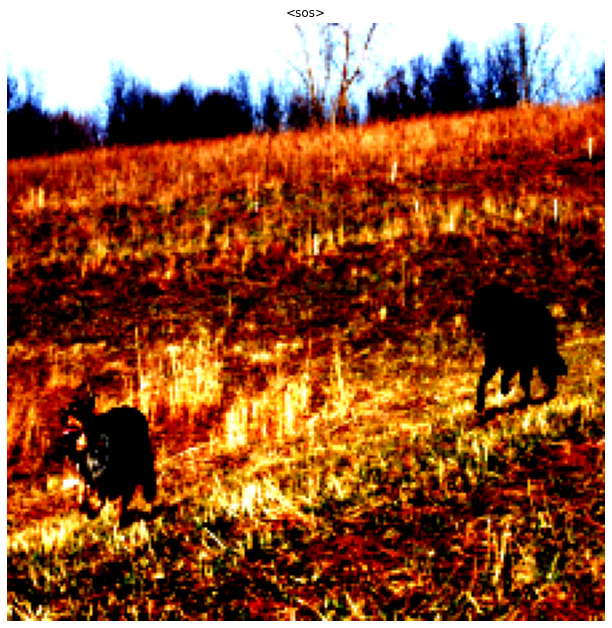

In [ ]:
import matplotlib.pyplot as plt
from torch.nn.utils.rnn import pack_padded_sequence

EnNet = ENet().to(device)
DeNet = DNet(vocab_size+1).to(device)
EnNet.load_state_dict(torch.load(open("/content/drive/MyDrive/Data/encoder.pth","rb"), map_location=torch.device('cpu')))
DeNet.load_state_dict(torch.load(open("/content/drive/MyDrive/Data/decoder.pth","rb"), map_location=torch.device('cpu')))
EnNet.eval()
DeNet.eval()

for img, cap, caps in loader:
    img, cap = torch.autograd.Variable(img).to(device), torch.autograd.Variable(cap).to(device)
    feats = EnNet(img)
    weights, sentences = DeNet(feats, cap)
    #targets = pack_padded_sequence(cap[:,1:], [len(caption)-1 for caption in cap[:,1:]], batch_first=True)[0]
    #sentences = pack_padded_sequence(sentences, [len(sentence)-1 for sentence in sentences], batch_first=True)[0]
    #print(targets)
    sentences = torch.max(sentences, dim=2)[1]

    fig = plt.figure(figsize=(15, 11))

    for i,w,s,c in zip(img, weights, sentences, cap):
        #fig.add_subplot(w.size(0)//2, w.size(0)//2+1, 1)
        plt.imshow(i.permute(1, 2, 0).to(torch.device("cpu")))
        plt.axis('off')
        plt.title("<sos>")
        '''
        cap_img = torch.nn.functional.interpolate(img, size=14).to(torch.device("cpu"))

        w = w.detach()

        for att in range(w.size(0)):
            if(s[att]!=TN.vocab.stoi["<pad>"]):
                fig.add_subplot(w.size(0)//2, w.size(0)//2+1, att+2)
                plt.imshow(cap_img.matmul(w[att].view(14,14)).to(torch.device("cpu")))
        '''
        print(TN.VectorToSentence(c))
        print(TN.VectorToSentence(s))
        break
    break